In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#IMPORTS
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from src.data.make_dataset import *
from src.data.modal_data import *

In [3]:
loc = 'nw2'
turbine = 'c02'
mode = 'whirling'
loc = 'nw2'
turbine = 'c02'
direction = 'ss'
# GET THE DATA
package_folder = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
data_folder = os.path.join(package_folder, 'data')

In [4]:
test_data_path = '_'.join([loc, turbine, 'SS2', 'test_data.parquet'])
test_turbine_data = pd.read_parquet(os.path.join(data_folder, 'raw', loc, test_data_path))
#remove duplicated index
duplicated_indices = test_turbine_data.index.duplicated(keep='first')
test_turbine_data = test_turbine_data[~duplicated_indices]
test_turbine_data.index = pd.to_datetime(test_turbine_data.index, utc=True)

wandelaar_weather_station_data = pd.read_parquet(os.path.join(data_folder,'external', loc, 'test_wandelaar_weather_data.parquet'))
westhinder_weather_station_data = pd.read_parquet(os.path.join(data_folder,'external', loc, 'test_westhinder_weather_data.parquet'))

mvbc_test_data = wandelaar_weather_station_data.copy()
mvbc_test_data[mvbc_test_data.filter(regex='Tide').columns] = westhinder_weather_station_data.filter(regex='Tide').values
#mvbc_test_data.rename(columns={mvbc_test_data.filter(regex='Tide').columns[0] :westhinder_weather_station_data.filter(regex='Tide').columns[0]}, inplace=True)
mvbc_test_data.isna().sum()
mvbc_test_data.index = pd.to_datetime(mvbc_test_data.index, utc=True)

In [5]:
from src.data.preprocessing import sin_cos_angle_inputs
selected_columns = ['mean_NW2_C02_rpm', 'mean_NW2_C02_pitch', 'mean_NW2_C02_power',
       'mean_NW2_C02_windspeed', 'sin_mean_NW2_C02_yaw',
       'cos_mean_NW2_C02_yaw', 'sin_mean_NW2_C02_winddirection',
       'cos_mean_NW2_C02_winddirection',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Air_temperature']
test_turbine_data_transformed = sin_cos_angle_inputs(test_turbine_data)
input_data = pd.concat([test_turbine_data_transformed, mvbc_test_data], axis=1)[selected_columns]

input_data.to_parquet(os.path.join(data_folder, 'processed', loc,'test_2023_06_12_predictions', '_'.join([loc, turbine, mode]) +'input.parquet'))

In [6]:
mpe_direction = \
        pd.DataFrame.from_records(
            test_turbine_data['mpe_'+loc.upper()+'_'+turbine.upper()+'_'+direction.upper()].explode().dropna().tolist(),
            index=test_turbine_data['mpe_'+loc.upper()+'_'+turbine.upper()+'_'+direction.upper()].explode().dropna().index,
            )

lower_freq = 0.6
upper_freq = 0.77

whirling = mpe_direction[(mpe_direction['mean_frequency'] < upper_freq) & (mpe_direction['mean_frequency'] > lower_freq)]
whirling.to_parquet(os.path.join(data_folder, 'processed', loc,'test_2023_06_12_predictions', '_'.join([loc, turbine, mode]) +'.parquet'))

In [7]:
mode_frequency_ = whirling['mean_frequency']
inputs_ = input_data.copy()
y = mode_frequency_.dropna()
X = inputs_.loc[y.index].dropna()
y = y.loc[X.index]

In [8]:
import pickle
models_folder = os.path.join(package_folder, 'models', loc)
model_path = os.path.join(models_folder, turbine, mode, '_'.join([loc, turbine, mode, 'catboost_model.pkl']))
with open(model_path, 'rb') as file:
    regr_model = pickle.load(file)

In [9]:
# Full model predictions
predictions = regr_model.predict(X)
predictions_df = pd.DataFrame(predictions, columns=['prediction', 'spread'], index=X.index)
predicted_value = predictions[:,0]
predicted_total_uncertainty = predictions[:,1]

# Virtual ensemble predictions
virtual_ensemble_preds = regr_model.virtual_ensembles_predict(X, prediction_type='TotalUncertainty', virtual_ensembles_count=500, ntree_end=1000) #, virtual_ensembles_count=100, ntree_end=200)
virtual_ensemble_preds_df = pd.DataFrame(virtual_ensemble_preds, columns=['prediction', 'knowledge uncertainty', 'data uncertainty'], index=X.index)

virtual_ensemble_preds_mean = virtual_ensemble_preds[:,0] # mean values predicted by a virtual ensemble
knowledge_uncertainty = virtual_ensemble_preds[:,1] # knowledge uncertainty predicted by a virtual ensemble
data_uncertainty = virtual_ensemble_preds[:,2] # average estimated data uncertainty

# uncertainty = knowledge_uncertainty + data_uncertainty
uncertainty_ = pd.Series(knowledge_uncertainty, index=X.index).copy()
uncertainty_moving_avg = pd.Series(uncertainty_, index=X.index).rolling(6*6, center=True).mean()

# save the predictions
predictions_df.to_parquet(os.path.join(data_folder, 'processed', loc, mode,'test_2023_06_12_predictions', '_'.join([loc, turbine, mode]) +'predictions.parquet'))
virtual_ensemble_preds_df.to_parquet(os.path.join(data_folder, 'processed', loc,mode,'test_2023_06_12_predictions', '_'.join([loc, turbine, mode]) +'virtual_ensemble_predictions.parquet'))

In [29]:
from src.smart_tracking.smart_tracking import smart_tracking
uncertainty_lim = 4.0609205553384383e-07 #1.645240287171251e-07 #9.598900289101693e-08
prediction_lim = 0.0182747553292923 #

smart_tracked_modes = smart_tracking(y, predictions_df['prediction'], uncertainty_, uncertainty_lim, prediction_lim)
smart_tracked_modes.to_parquet(os.path.join(data_folder, 'processed', loc,'test_2023_06_12_predictions', '_'.join([loc, turbine, mode]) +'smart_tracked_modes.parquet'))

In [30]:
from src.data.utils import get_input_data
from src.data.harmonics import *

harmonics_data = harmonics(test_turbine_data.filter(regex='rpm'), [1,3,6, 9])

C:\Users\Max\AppData\Local\Temp\ipykernel_31672\2197626686.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend1.legendHandles:
C:\Users\Max\AppData\Local\Temp\ipykernel_31672\2197626686.py:53: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in combined_legend.legendHandles:


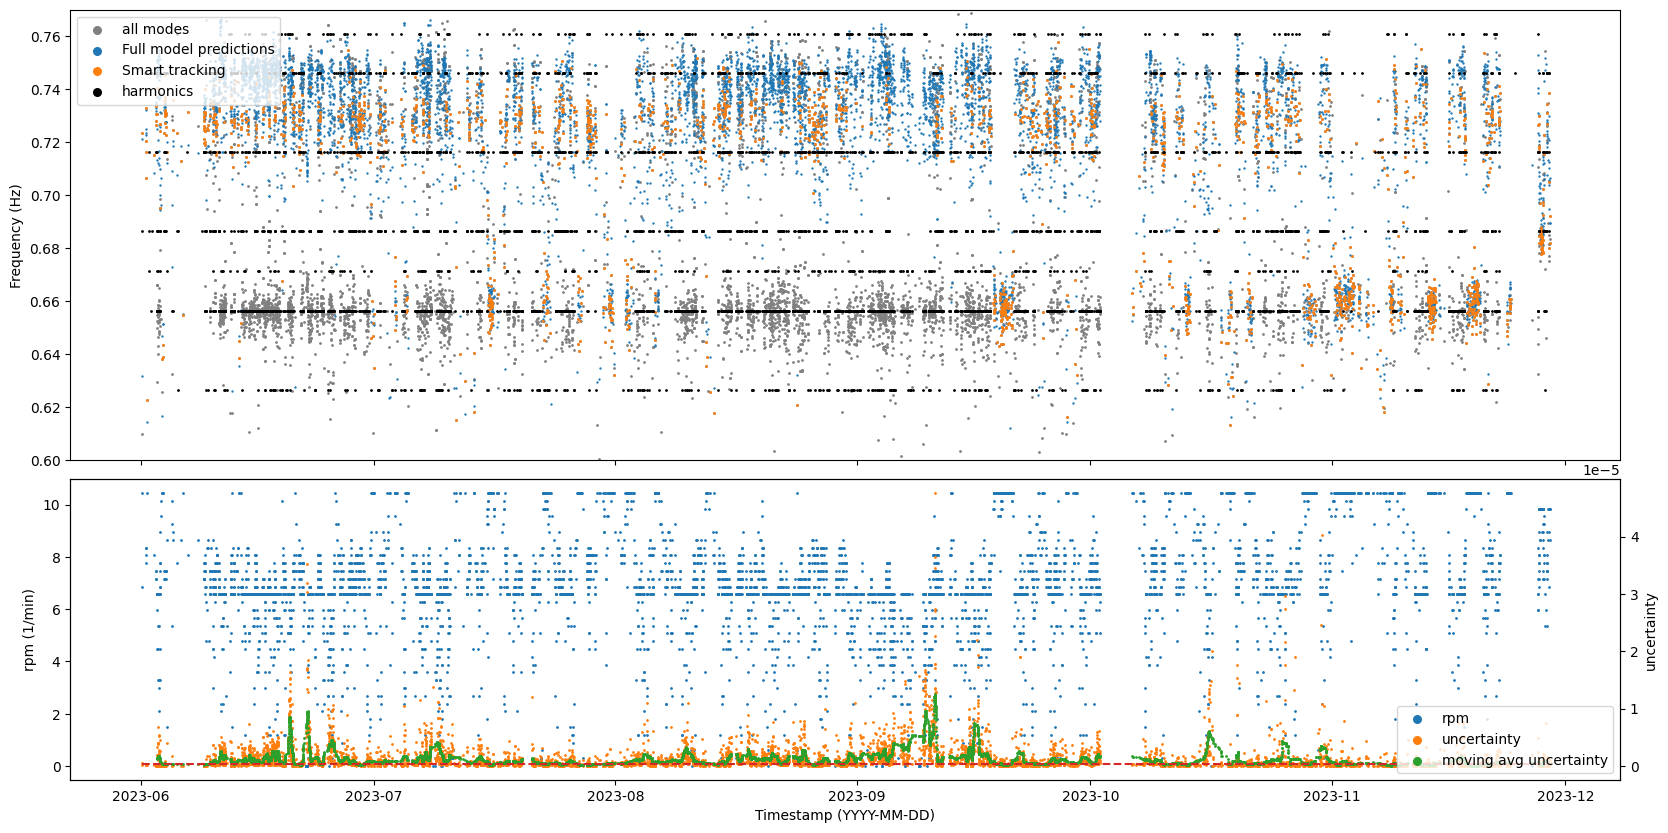

In [31]:
import matplotlib.pyplot as plt
import datetime

# Create two subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True, gridspec_kw={'height_ratios': [3, 2]})

# Plot on the first subplot
ax1.scatter(y.index, y, s=1, color='grey')
ax1.scatter(predictions_df.index, predictions_df['prediction'], s=0.5, color='tab:blue', label='Full model predictions')
ax1.scatter(smart_tracked_modes.index, smart_tracked_modes['frequency'], s=1, color='tab:orange', label='Smart tracking')
for harmonic in harmonics_data.columns:
    ax1.scatter(harmonics_data.index, harmonics_data[harmonic], color='k', s=1)

#ax1.plot(harmonics_data, color='k', linestyle='--', linewidth=0.5, label='harmonics')
#ax1.scatter(y_train.index, y_train, s=3, color='tab:blue', label='training data')
#ax1.scatter(y.index, predicted_value, s=2, color='tab:orange', label='Full model predictions')


#ax1.scatter(y.index, virtual_ensemble_preds_mean, s=2, color='tab:green', label='Virtual ensemble mean predictions')

ax1.set_ylim(lower_freq, upper_freq)
legend1 = ax1.legend(loc='upper left', labels = ['all modes', 'Full model predictions', 'Smart tracking', 'harmonics']) 
for handle in legend1.legendHandles:
    handle.set_sizes([30])
ax1.set_ylabel('Frequency (Hz)')


# Plot on the second subplot
ax2.scatter(X.index, X.filter(regex='rpm'), label='rpm', s=1, color='tab:blue')
ax2.set_ylabel('rpm (1/min)')
ax2.set_xlabel('Timestamp (YYYY-MM-DD)')
#ax2.scatter(X.index, data_uncertainty, label='data uncertainty', s=1, color='tab:blue')
#ax2.set_ylim(0, 1e-5)

ax3 = ax2.twinx()
ax3.scatter(uncertainty_.index,uncertainty_, label='uncertainty', s=1, color='tab:orange')
ax3.scatter(uncertainty_moving_avg.index,uncertainty_moving_avg, label='moving avg uncertainty', s=1, color='tab:green')

ax3.hlines(uncertainty_lim, uncertainty_.index[0], uncertainty_.index[-1], color='tab:red', linestyles='dashed')
ax3.set_ylabel('uncertainty')
#ax3.set_ylim(0, 3*1e-6)

# Collect handles and labels for ax2 and ax3
handles2, labels2 = ax2.get_legend_handles_labels()
handles3, labels3 = ax3.get_legend_handles_labels()

# Combine handles and labels
combined_handles = handles2 + handles3
combined_labels = labels2 + labels3

# Create a single combined legend
combined_legend = plt.legend(combined_handles, combined_labels, loc='lower right')
for handle in combined_legend.legendHandles:
    handle.set_sizes([30])

# Set shared x-axis properties
plt.subplots_adjust(hspace=0.05)  # Adjust this value as needed

plt.show()
plt.close()

C:\Users\Max\AppData\Local\Temp\ipykernel_31672\3276484546.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handles in legend.legendHandles:


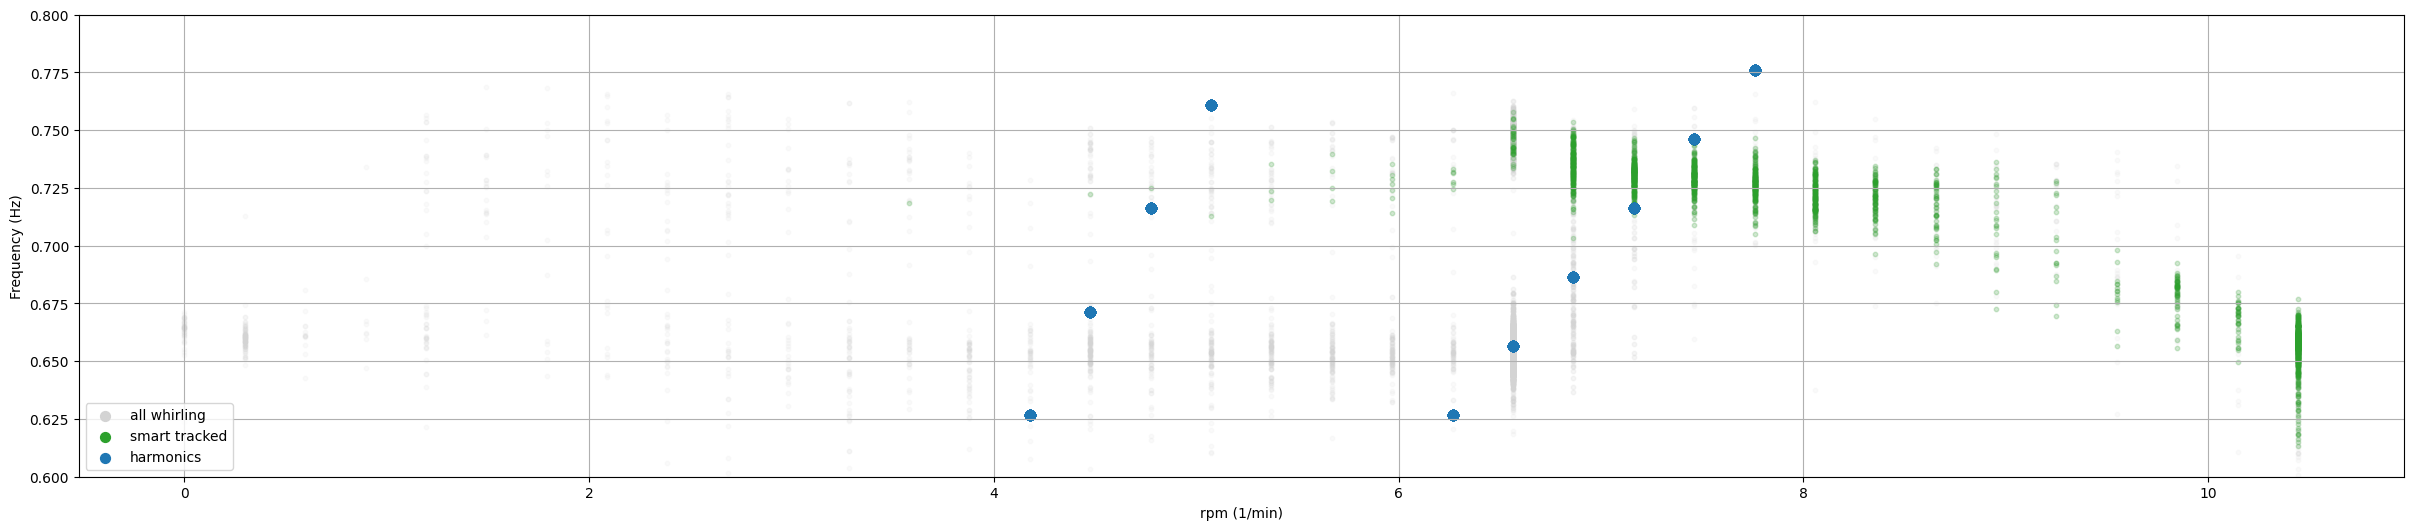

In [32]:
campbell_data = pd.DataFrame({'frequency': y}, index=y.index)
X_ = X[~X.index.duplicated(keep='first')]
campbell_data['rpm'] = X_.filter(regex='rpm').loc[campbell_data.index]

harmonics_data['rpm'] = test_turbine_data.filter(regex='rpm').loc[harmonics_data.index]
smart_tracked_modes['rpm'] = X_.filter(regex='rpm').loc[smart_tracked_modes.index]

plt.figure(figsize=(30,6))
plt.scatter(campbell_data['rpm'], campbell_data['frequency'], s=10, alpha=0.1, color='lightgrey')

#plt.scatter(mpe_ss_data_lowrpm.index, mpe_ss_data_lowrpm['mean_frequency'], s=10, alpha=0.6, color='tab:green')
plt.scatter(smart_tracked_modes['rpm'], smart_tracked_modes['frequency'], s=10, alpha=0.2, color='tab:green')
for harmonic in harmonics_data.columns[:-1]:
    plt.scatter(harmonics_data['rpm'], harmonics_data[harmonic], s=50, alpha=1.0, color='tab:blue')

plt.ylim(0.6, 0.8)
legend = plt.legend(loc='lower left', labels=['all whirling', 'smart tracked', 'harmonics'])
for handles in legend.legendHandles:
    handles.set_sizes([50])
    handles.set_alpha(1.0)
plt.xlabel('rpm (1/min)')
plt.ylabel('Frequency (Hz)')
plt.grid()
plt.show()
plt.close()

In [33]:
uncertainty_.index.duplicated().sum()

544

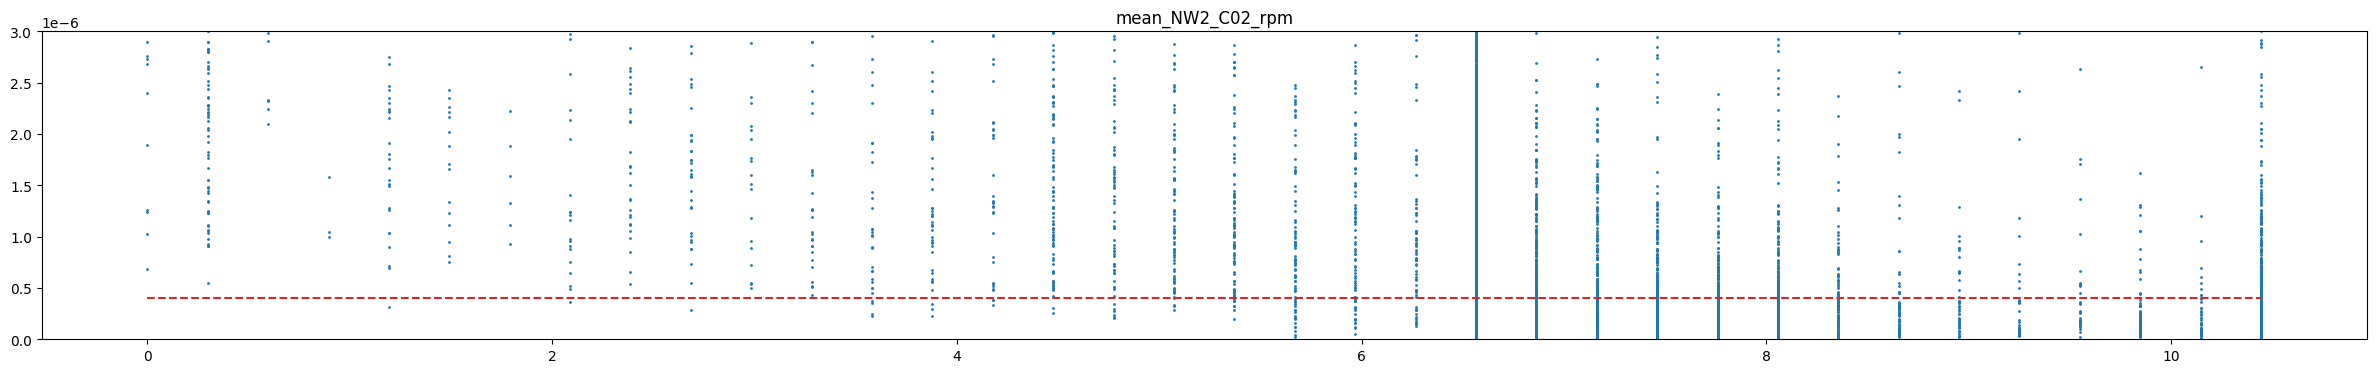

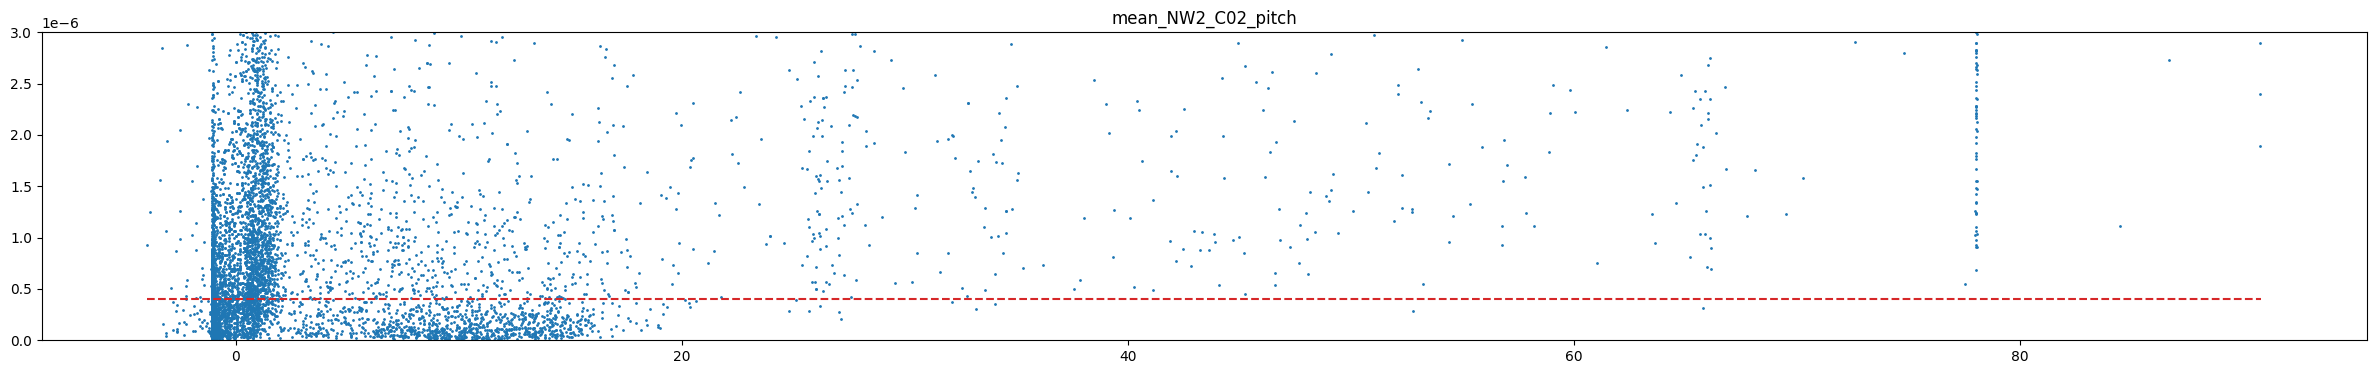

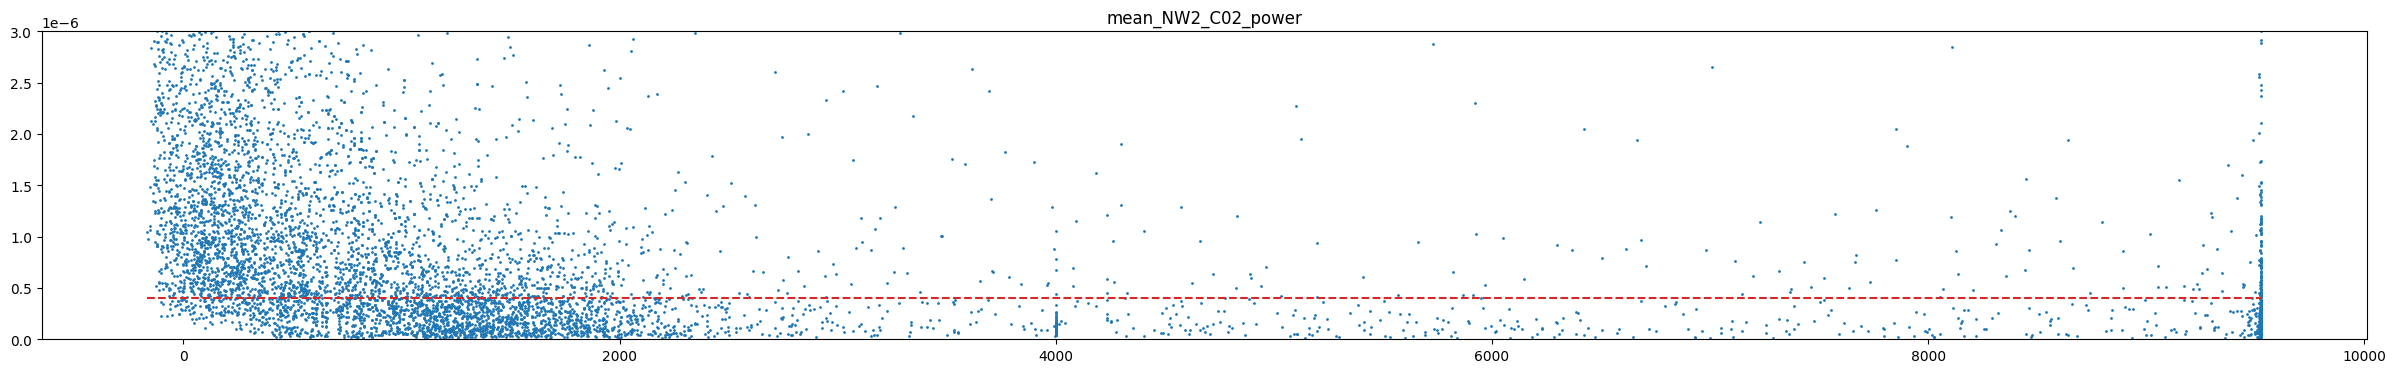

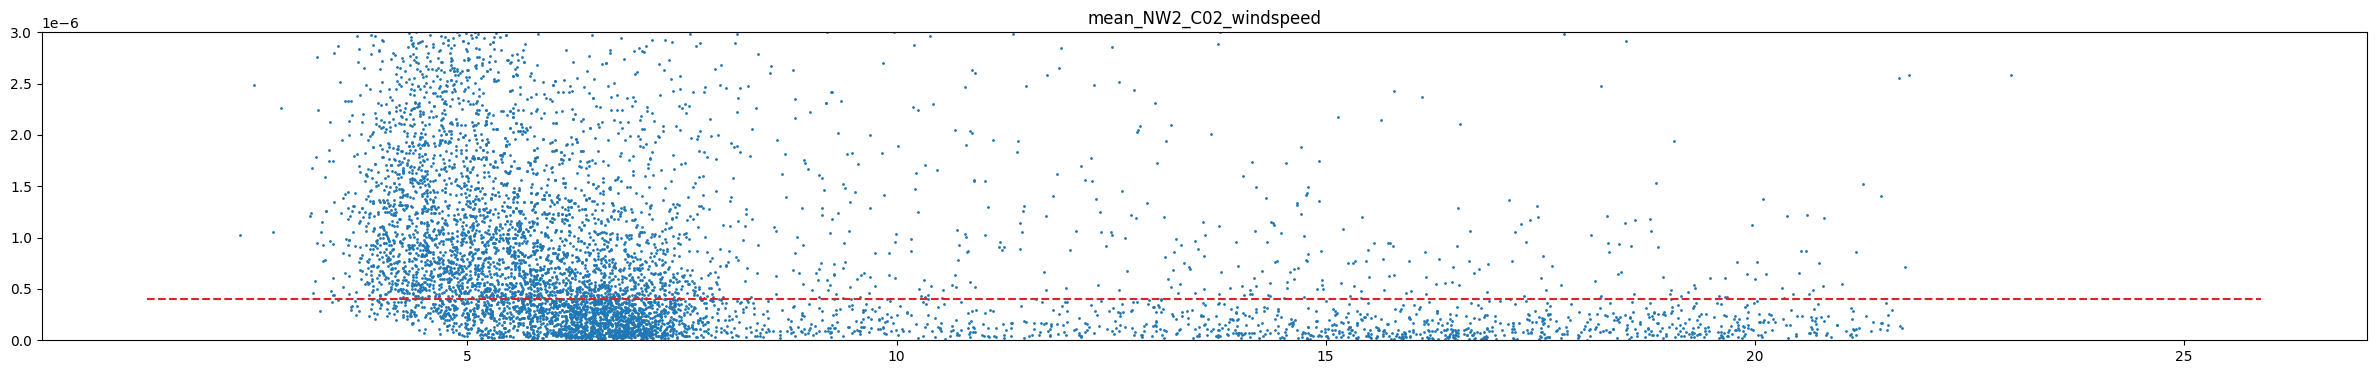

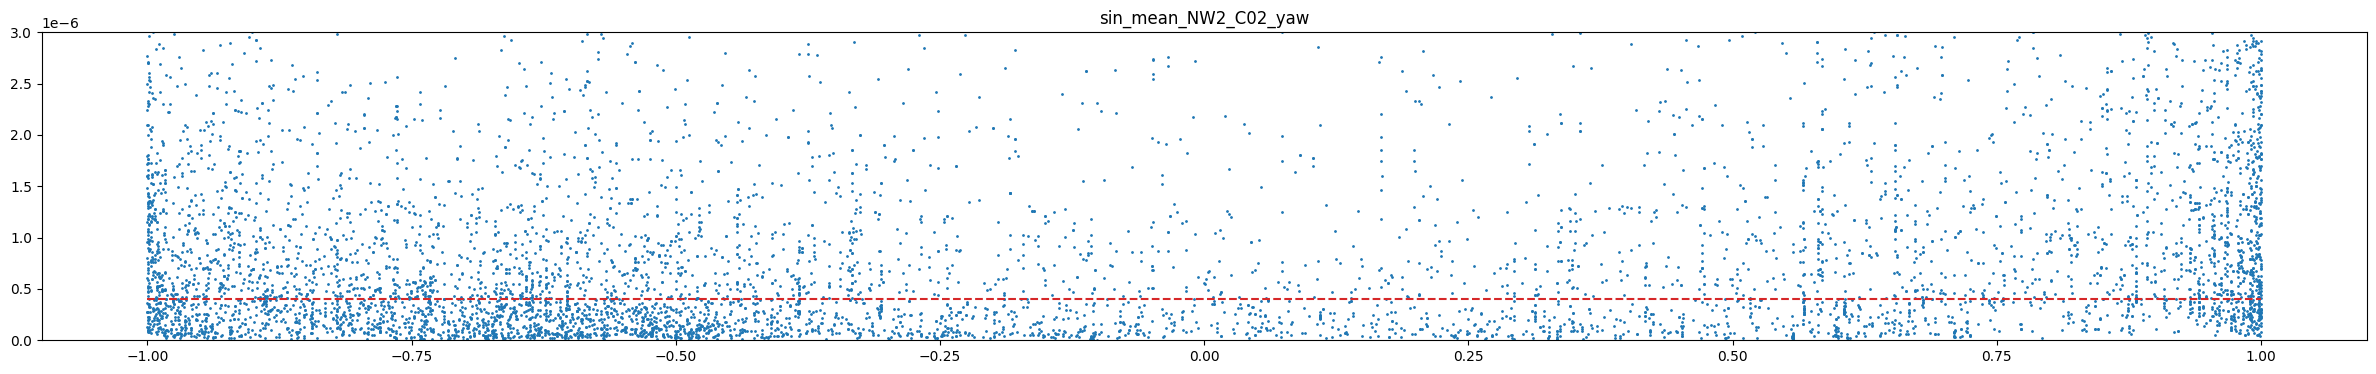

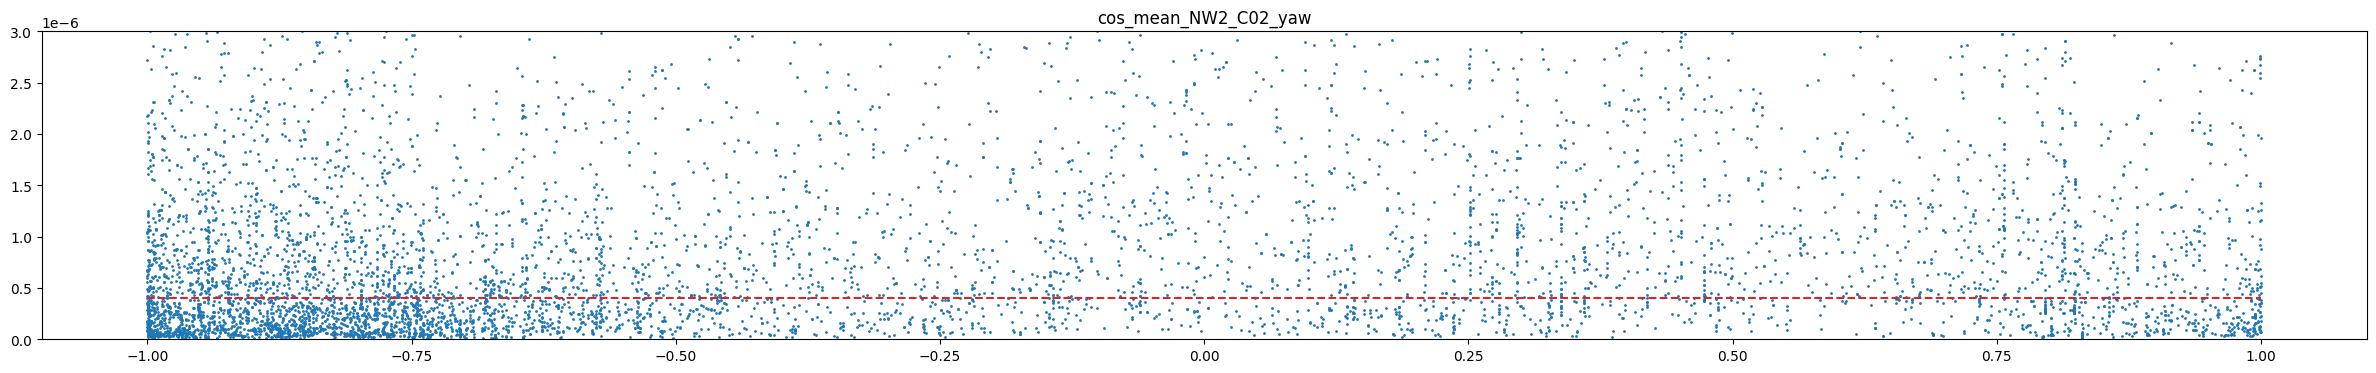

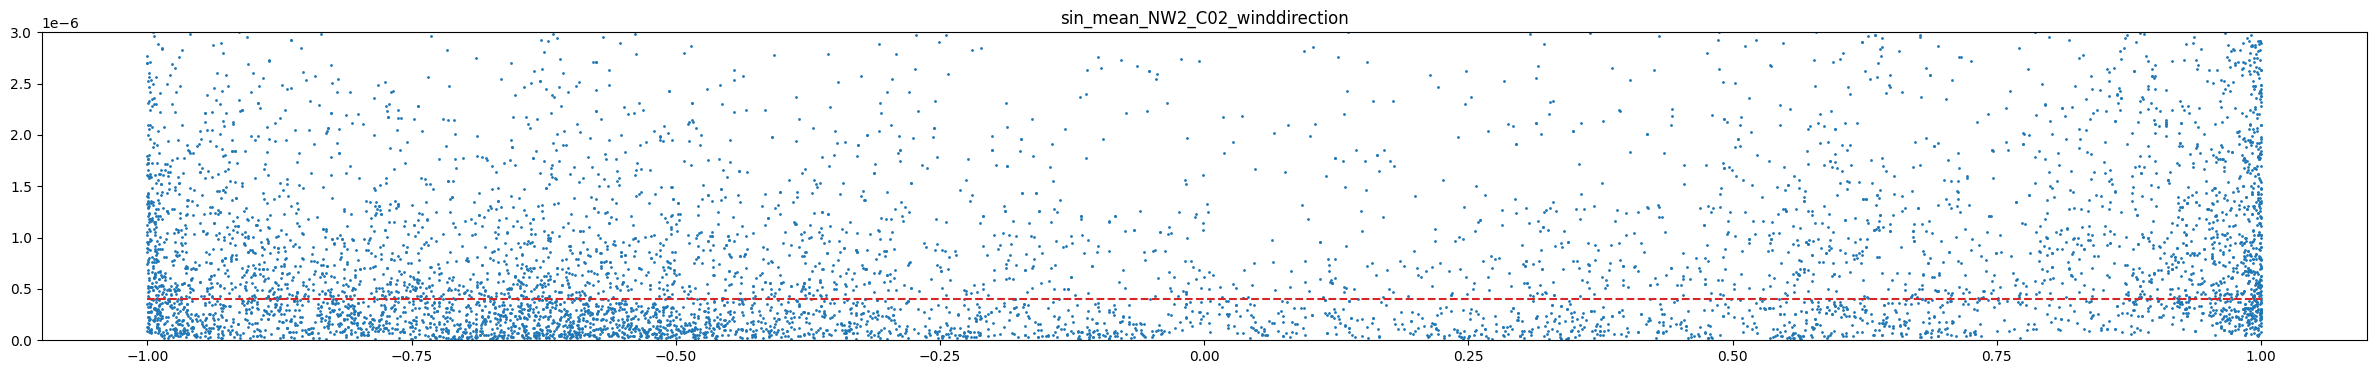

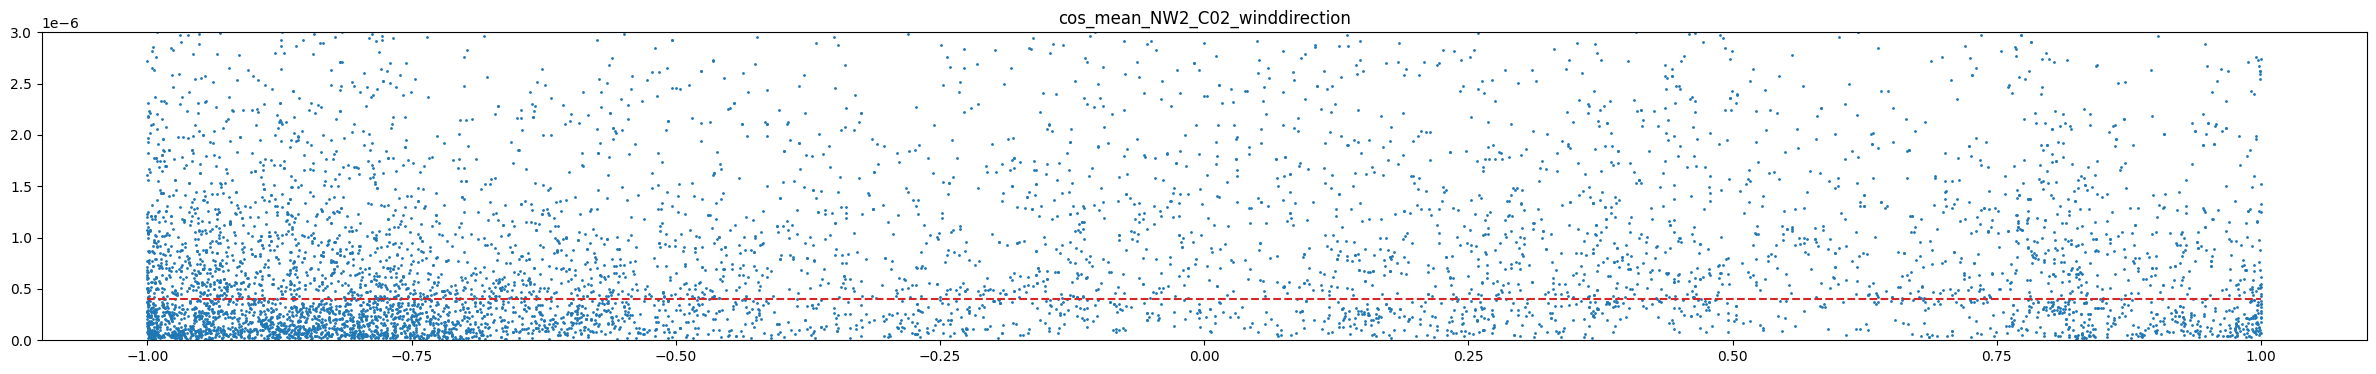

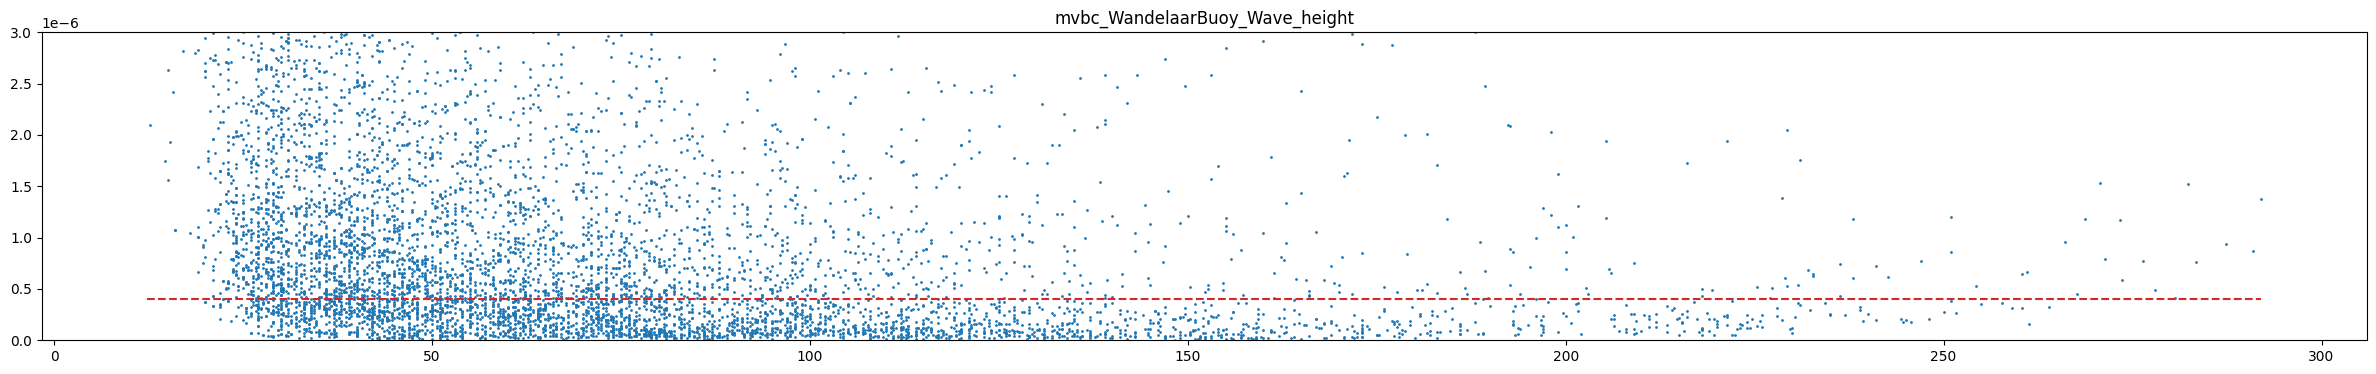

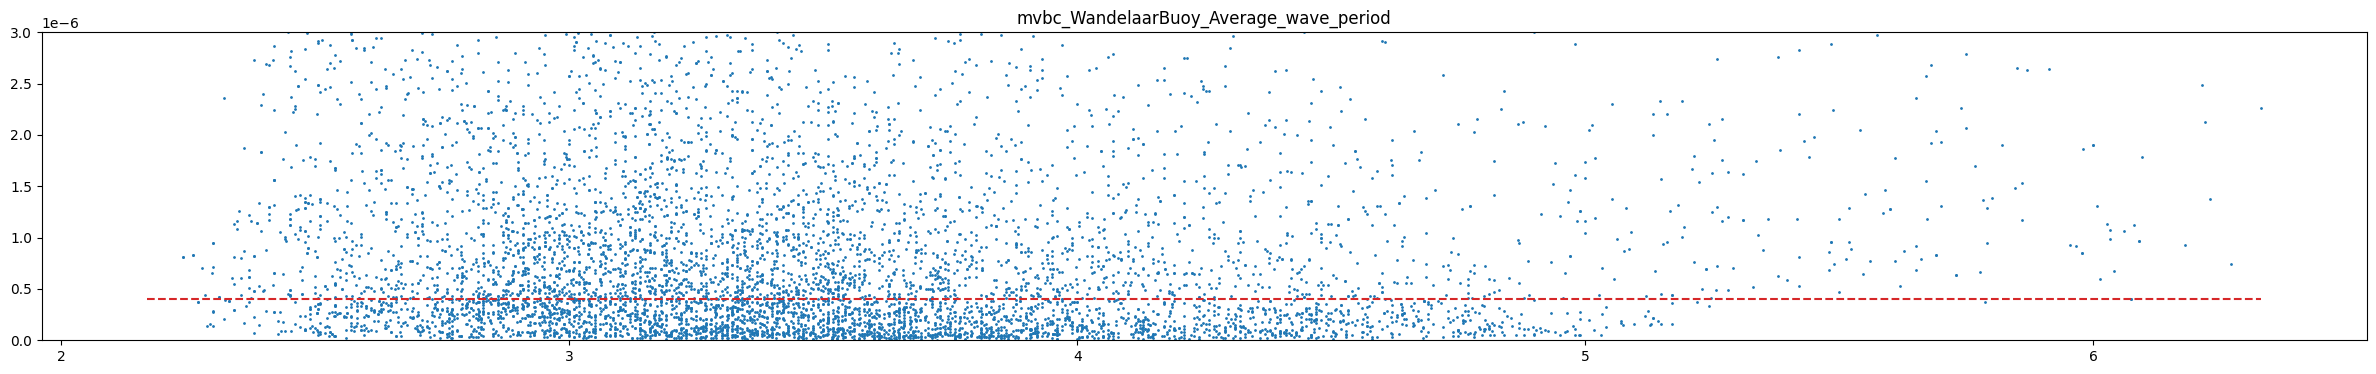

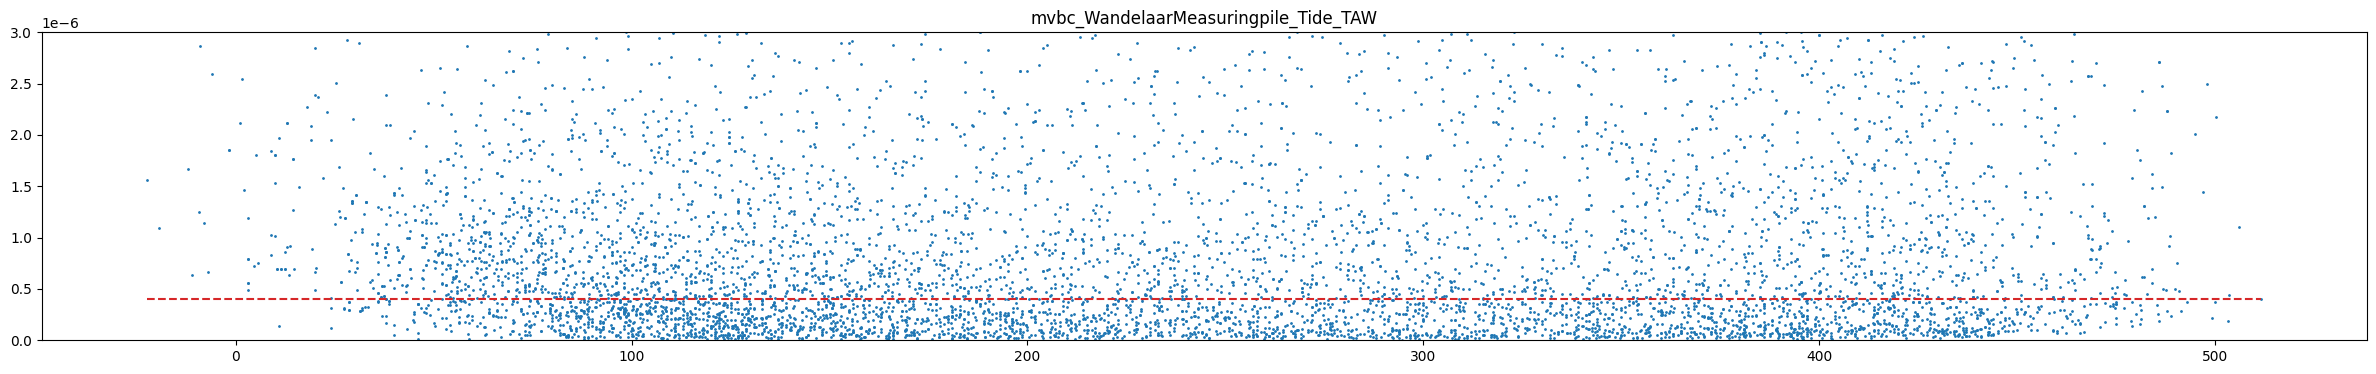

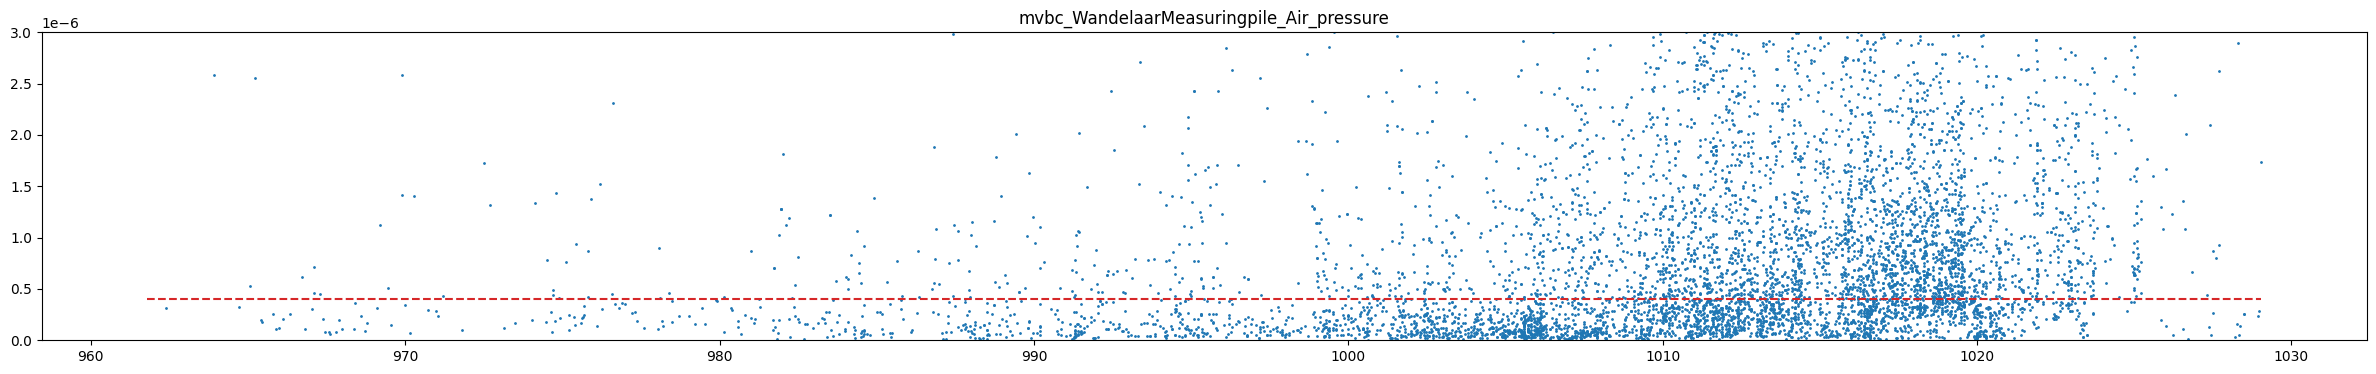

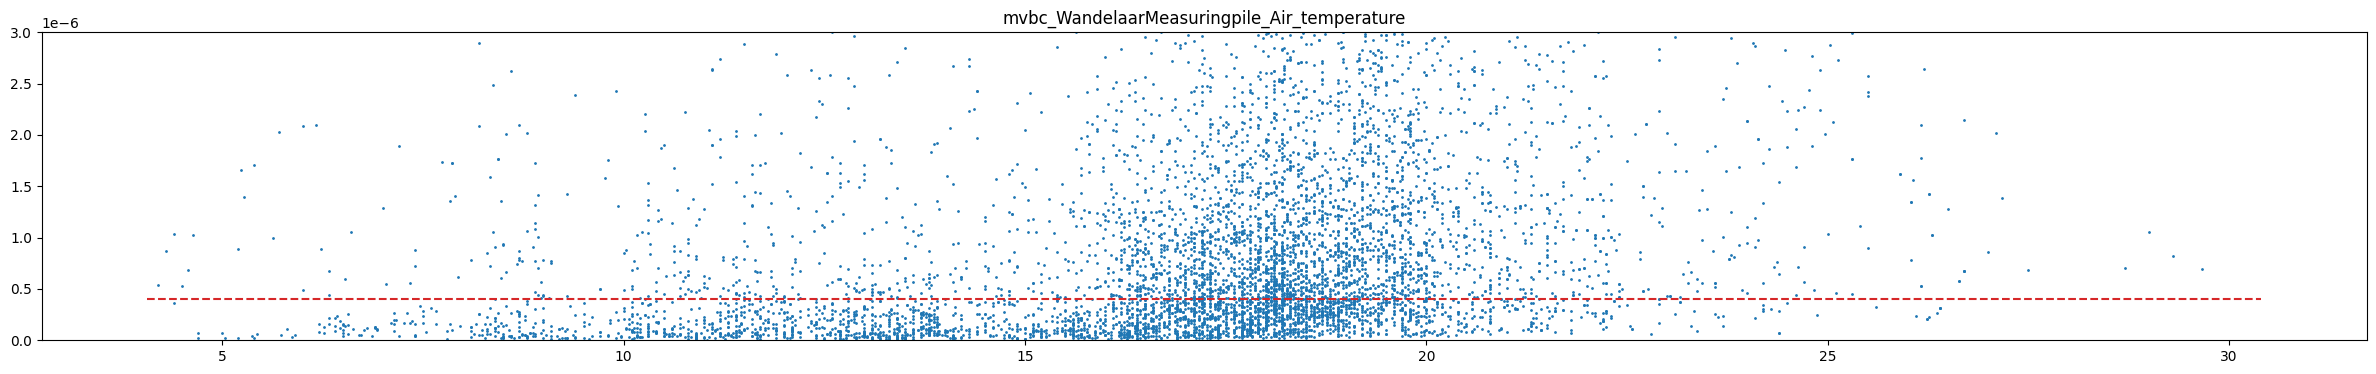

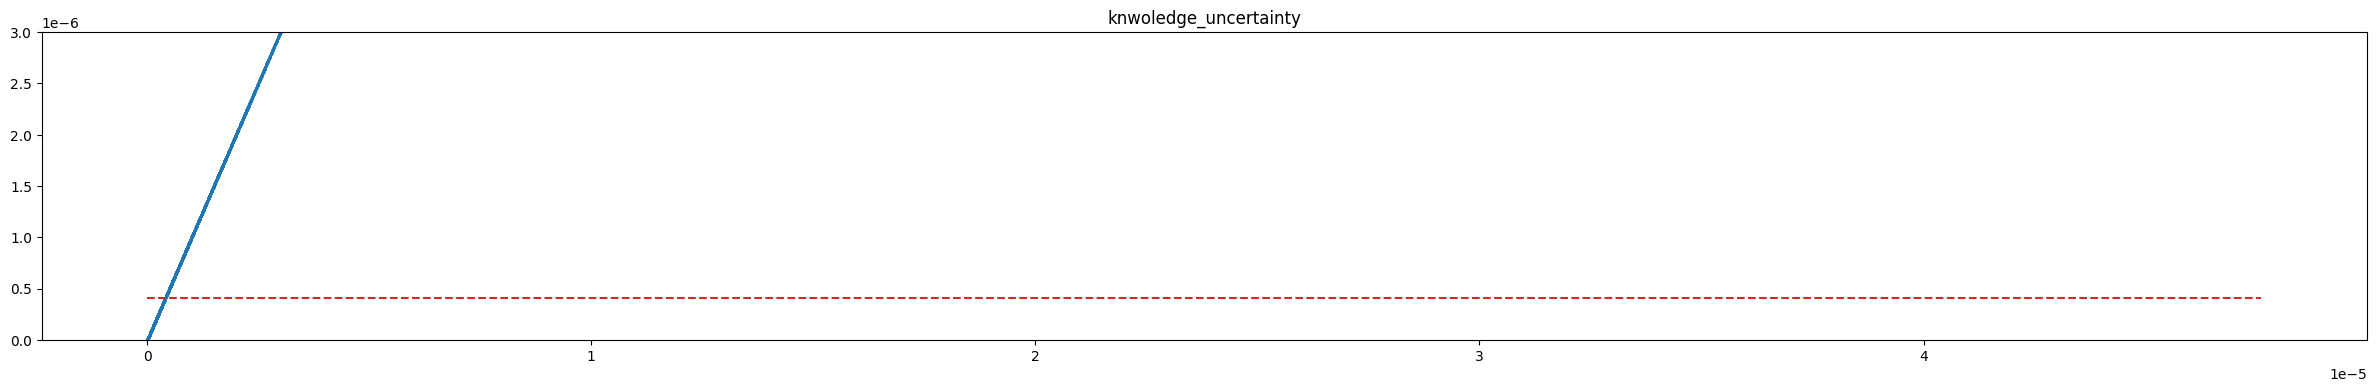

In [34]:
X['knwoledge_uncertainty'] = knowledge_uncertainty
for col in X.columns:
    plt.figure(figsize=(30,4))
    plt.scatter(X[col] , X['knwoledge_uncertainty'],  s=1, color='tab:blue')
    plt.title(col)
    plt.ylim(0, 3e-6)
    plt.hlines(uncertainty_lim, X[col].min(), X[col].max(), color='tab:red', linestyles='dashed')
    plt.show()


In [35]:
smart_tracked_modes

,frequency,difference,rpm
timestamp,,,
2023-06-01 04:20:00+00:00,0.723370,0.001972,6.864
2023-06-01 15:10:00+00:00,0.716351,0.006244,8.057
2023-06-01 15:20:00+00:00,0.706644,0.016812,8.356
2023-06-01 15:30:00+00:00,0.732951,0.000654,7.759
2023-06-01 15:40:00+00:00,0.720579,0.004384,8.356
...,...,...,...
2023-11-28 21:10:00+00:00,0.705083,0.015902,8.952
2023-11-28 21:30:00+00:00,0.738530,0.008722,6.864
2023-11-28 22:40:00+00:00,0.680038,0.014693,9.848
